# ReRank

Now, that you've learned keyword search and dense retrieval, **Rerank is a way to improve them both**, and it is actually the second component of semantic search in addition to dense retrieval. 

Rerank is a way for a large language model to sort search results from best to worst based on the relevance they have with respect to the query. 

## Setup

Load needed API keys and relevant Python libaries.

In [2]:
# !pip install cohere 
# !pip install weaviate-client

In [71]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [72]:
import cohere
co = cohere.Client(os.environ['COHERE_API_KEY'])

In [73]:
import weaviate
auth_config = weaviate.auth.AuthApiKey(
    api_key=os.environ['WEAVIATE_API_KEY'])

In [74]:
client = weaviate.Client(
    url=os.environ['WEAVIATE_API_URL'],
    auth_client_secret=auth_config,
    additional_headers={
        "X-Cohere-Api-Key": os.environ['COHERE_API_KEY'],
    }
)

## Dense Retrieval

In [77]:
from utils import dense_retrieval

In [78]:
query = "What is the capital of Canada?"

In [126]:
dense_retrieval_results = dense_retrieval(query, client)

In [127]:
# function that would help us print the results nicely
from utils import print_result

In [128]:
print_result(dense_retrieval_results)

item 0
_additional:{'distance': -150.8129}

lang:en

text:The governor general of the province had designated Kingston as the capital in 1841. However, the major population centres of Toronto and Montreal, as well as the former capital of Lower Canada, Quebec City, all had legislators dissatisfied with Kingston. Anglophone merchants in Quebec were the main group supportive of the Kingston arrangement. In 1842, a vote rejected Kingston as the capital, and study of potential candidates included the then-named Bytown, but that option proved less popular than Toronto or Montreal. In 1843, a report of the Executive Council recommended Montreal as the capital as a more fortifiable location and commercial centre, however, the Governor General refused to execute a move without a parliamentary vote. In 1844, the Queen's acceptance of a parliamentary vote moved the capital to Montreal.

title:Ottawa

url:https://en.wikipedia.org/wiki?curid=22219

views:2000


item 1
_additional:{'distance': -150

So, let's take a look at these results. The first one is correct, It's Ottawa. Then, we have some noisy ones. Toronto is not the capital of Canada. And then, we also have Quebec city, which is the wrong answer. And why does this happen? Well, let me show you. 

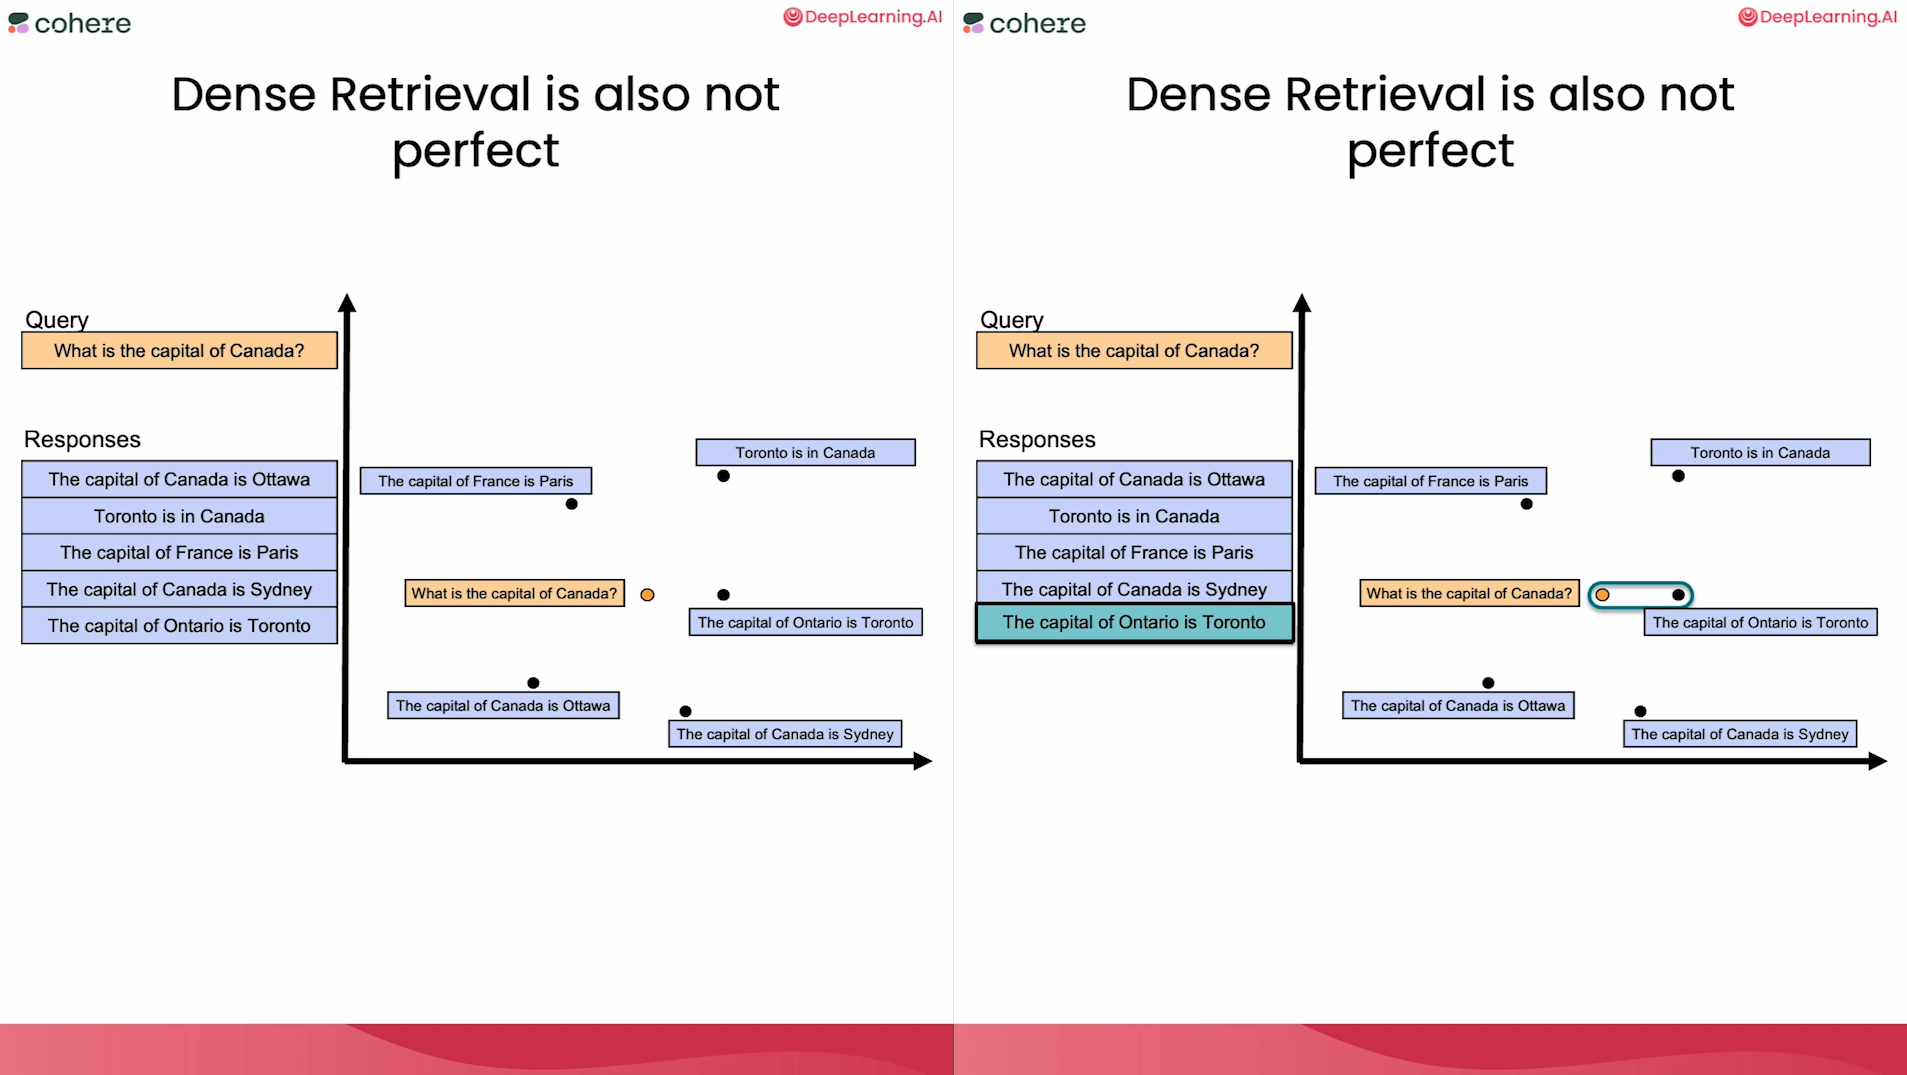

Here's a small pictorial example. The answers are different, but it's for getting the idea. So, the query says, what is the capital of Canada? And let's say that the possible responses are these five. The capital of Canada is Ottawa, which is correct. Toronto is in Canada, which is correct, but irrelevant to the question. The capital of France is Paris, which is also correct, but not the answer to the question. Then, a wrong sentence. The capital of Canada is Sydney, which is not correct. And then, a sentence says the capital of Ontario is Toronto, which is true, but also not answering the questions.  What happens when we do dense retrieval here? Well, let's say that these sentences are here. The capital of Canada is Ottawa, Toronto is in Canada, the capital of France is Paris, the capital of Canada is Sydney, and the capital of Ontario is Toronto. 

So, in an embedding, let's just imagine that they're located over here. Now, remember that the way dense retrieval works is it puts the query inside the embedding and then it returns the closest of the responses which in this case is the capital of Ontario is Toronto. 

Dense retrieval looks at similarities, so it returns the response that is the most similar to the question. 
This may not be the correct answer, this may not even be a true statement, it's just a sentence that happens to be close to the question semantically. 

So, therefore, dense retrieval has the potential to return things that are not necessarily the answer. How do we fix this? Well, this is where Rerank comes into play.  


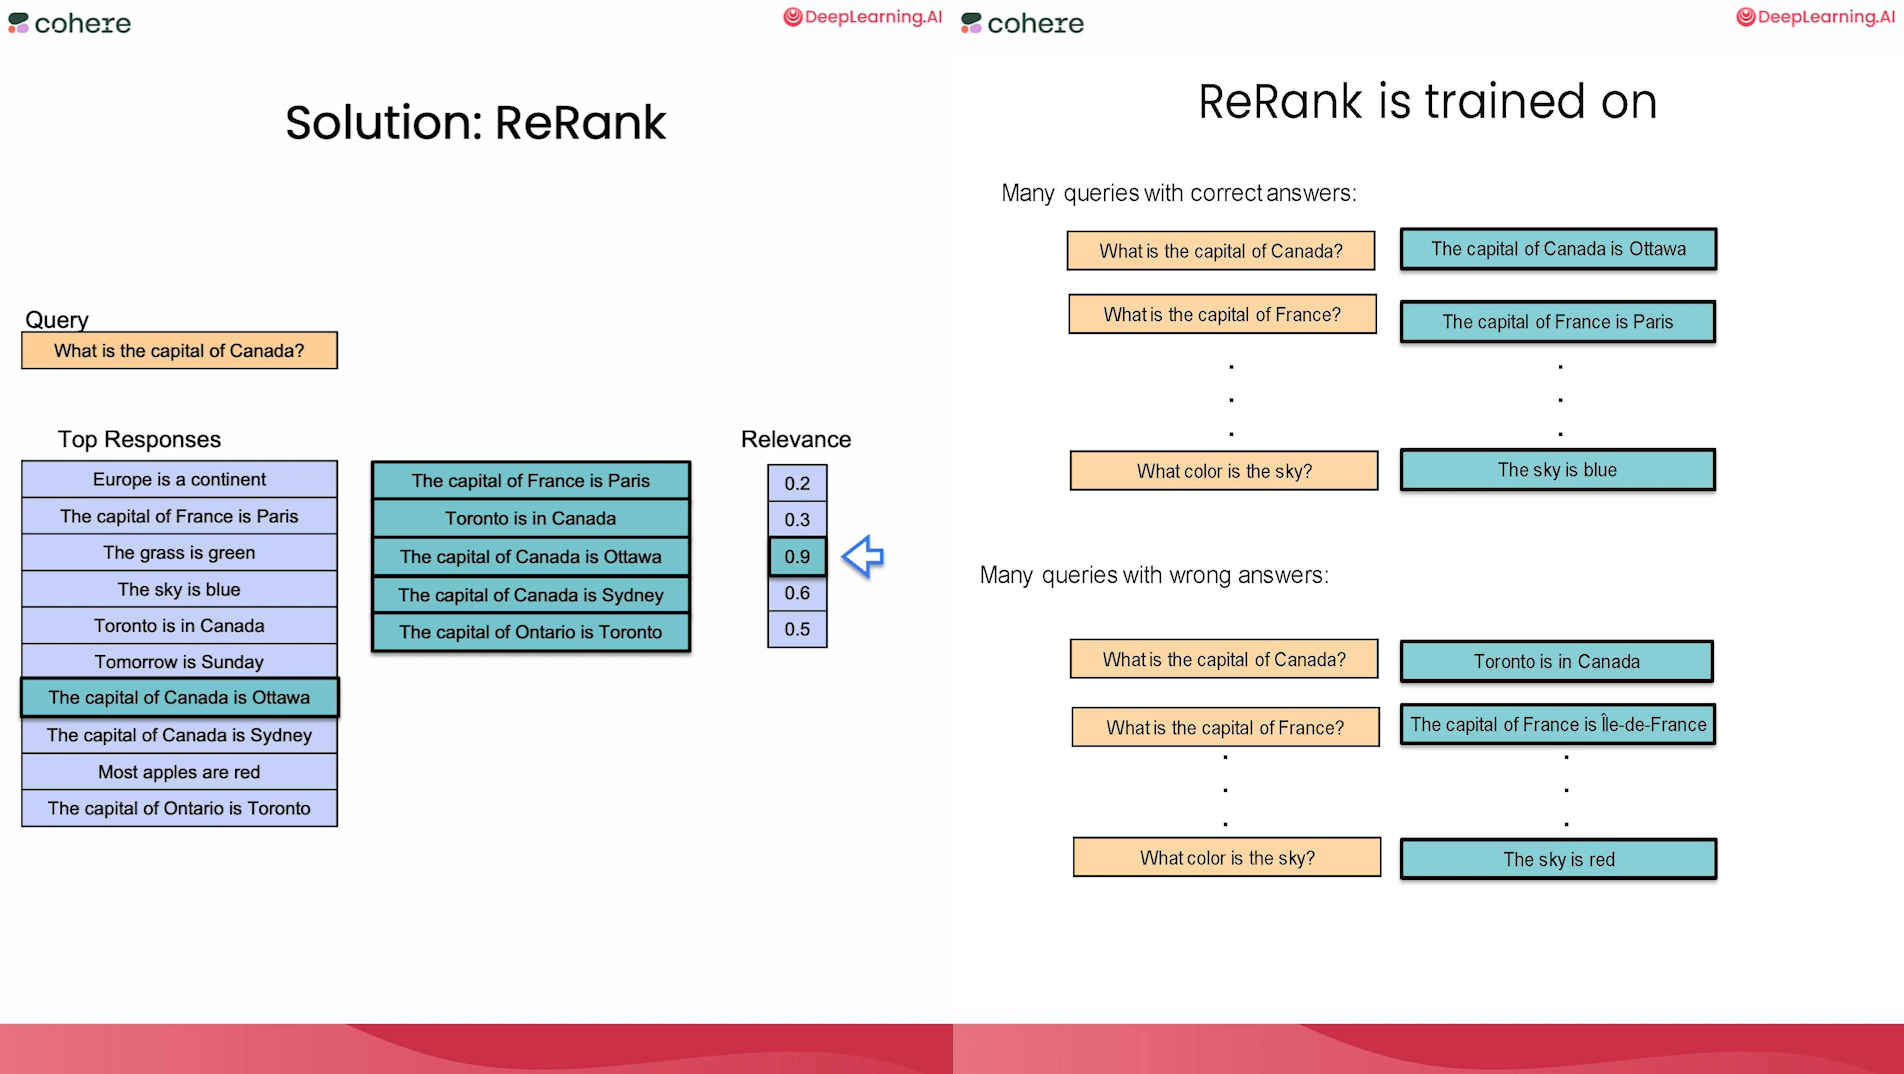

Now, let me show you a small example of Rerank. Let's say that the query is what is the capital of Canada, and we have 10 possible answers, and as you can see some of these are relevant to the question and some of them are not. 
So, when we use dense retrieval, it gives us the top five, let's say, the five responses that are the most similar to the query.

And let's say they are these ones over here, but we don't know which one is the response. We just have five sentences that are pretty close to the query. So, here is where Rerank comes into play. 

Rerank assigns to each query response pair a relevant score that tells you how relevant the answer is with respect to the query. It could also be a document. So, how relevant the document is with respect to the query. As you can see, the highest relevance here was 0.9, which corresponds to the capital of Canada is Ottawa, which is the correct answer. 

So, that is what Rerank does. You may be wondering how Rerank gets trained. Well, the way train re-rank is by giving it a lot of good pairs. So, that's a pair where the query and the response are very relevant, or when the query and document are very relevant, and training it to give those high relevance scores and then also giving it a big set of wrong query responses. So, query responses where the response does not correspond to the query. It may be close, but it may not correspond to it or also a document, a document that may not correspond to the query and if you train a model to give high scores to the good query response pairs and low scores to the bad query response pairs then you have the re-rank model that assigns a relevance and the relevance is high when you have a query and a response that are very related. 

## Improving Keyword Search with ReRank

In [84]:
from utils import keyword_search

In [85]:
query_1 = "What is the capital of Canada?"

In [ ]:
query_1 = "What is the capital of Canada?"
results = keyword_search(query_1,
                         client,
                         properties=["text", "title", "url", "views", "lang", "_additional {distance}"],
                         num_results=3
                        )

for i, result in enumerate(results):
    print(f"i:{i}")
    print(result.get('title'))
    print(result.get('text'))

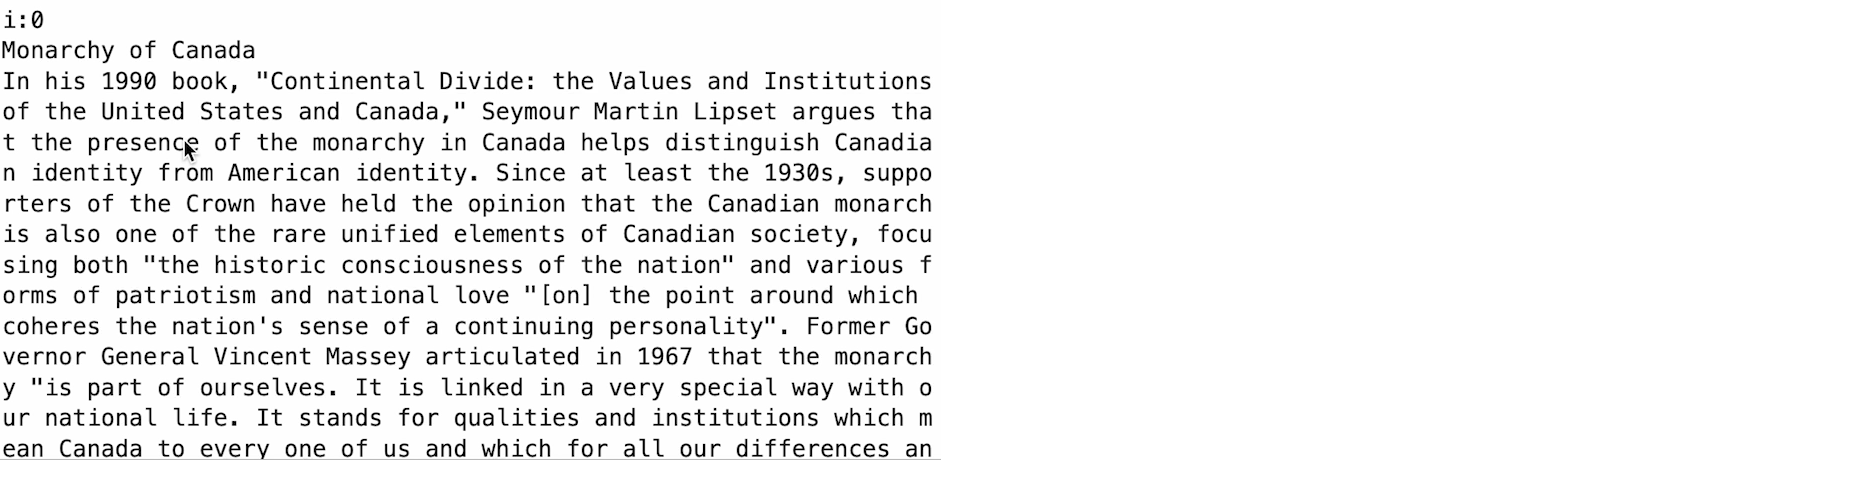

Why does it not work so well? Well, because keyword search is finding documents that have a lot of words in common with the query, but Keyword Search can't really tell if you're answering the questions. All these articles here have a lot of words in common with the query, but they're not the answer.  

In [ ]:
query_1 = "What is the capital of Canada?"
results = keyword_search(query_1,
                         client,
                         properties=["text", "title", "url", "views", "lang", "_additional {distance}"],
                         num_results=500
                        )

for i, result in enumerate(results):
    print(f"i:{i}")
    print(result.get('title'))
    #print(result.get('text'))

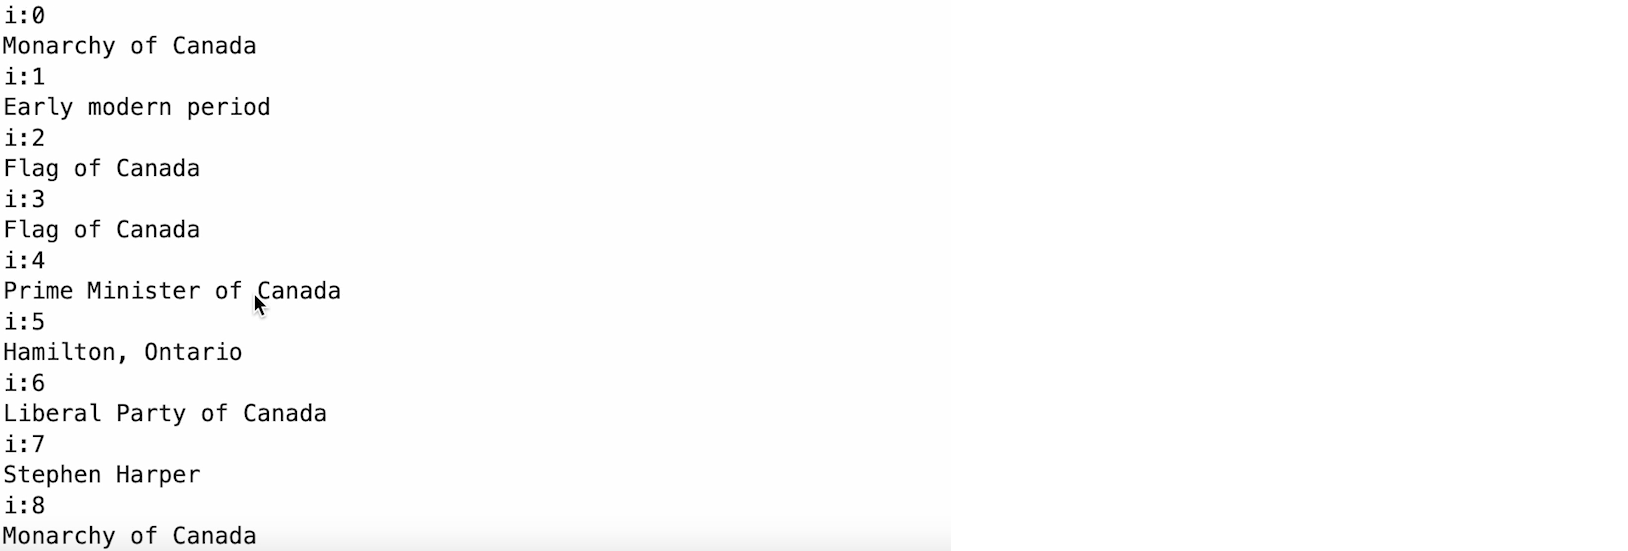

I'm not going to print the text, only the title. So here, we have 500 top results. That's a lot of them. How do we find if one of these has the answer. Well, that's where re-rank comes into play. 

This function over here re-ranks the responses and it outputs the top 10. 

In [113]:
def rerank_responses(query, responses, num_responses=10):
    reranked_responses = co.rerank(
        model = 'rerank-english-v2.0',
        query = query,
        documents = responses,
        top_n = num_responses,
        )
    return reranked_responses

In [114]:
texts = [result.get('text') for result in results]
reranked_text = rerank_responses(query_1, texts)

In [115]:
for i, rerank_result in enumerate(reranked_text):
    print(f"i:{i}")
    print(f"{rerank_result}")
    print()

i:0
RerankResult<document['text']: Selection of Ottawa as the capital of Canada predates the Confederation of Canada. The selection was contentious and not straightforward, with the parliament of the United Province of Canada holding more than 200 votes over several decades to attempt to settle on a legislative solution to the location of the capital., index: 407, relevance_score: 0.9875684>

i:1
RerankResult<document['text']: Montreal was the capital of the Province of Canada from 1844 to 1849, but lost its status when a Tory mob burnt down the Parliament building to protest the passage of the Rebellion Losses Bill. Thereafter, the capital rotated between Quebec City and Toronto until in 1857, Queen Victoria herself established Ottawa as the capital due to strategic reasons. The reasons were twofold. First, because it was located more in the interior of the Province of Canada, it was less susceptible to attack from the United States. Second, and perhaps more importantly, because it la

Notice that this actually picked up the answer. It picked up Ottawa as the capital of Canada. The relevant score is very high. It's very close to one, It's 0.98. 

## Improving Dense Retrieval with ReRank

In [116]:
from utils import dense_retrieval

In [117]:
query_2 = "Who is the tallest person in history?"

I'm gonna use this dense retrieval function, and let's give it a slightly hard question. Let's give it the question who is the tallest person in history? This would be a hard question for keyword search because it may surface articles with the word history or the word person, it may not actually pick up the meaning of the question, but let's hope that dense retrieval can do better. 

In [130]:
results = dense_retrieval(query_2,client)

In [132]:
for i, result in enumerate(results):
    print(f"i:{i}")
    print(result.get('title'))
    print(result.get('text'))
    print()

i:0
Robert Wadlow

i:1
Manute Bol

i:2
Sultan Kösen

i:3
Sultan Kösen

i:4
Netherlands

i:5
Robert Wadlow

i:6
Randy Johnson

i:7
Manute Bol

i:8
Harald Hardrada

i:9
Manute Bol



In [121]:
texts = [result.get('text') for result in results]
reranked_text = rerank_responses(query_2, texts)

In [122]:
for i, rerank_result in enumerate(reranked_text):
    print(f"i:{i}")
    print(f"{rerank_result}")
    print()

i:0
RerankResult<document['text']: Robert Pershing Wadlow (February 22, 1918 July 15, 1940), also known as the Alton Giant and the Giant of Illinois, was a man who was the tallest person in recorded history for whom there is irrefutable evidence. He was born and raised in Alton, Illinois, a small city near St. Louis, Missouri., index: 0, relevance_score: 0.9734939>

i:1
RerankResult<document['text']: Sultan Kösen (born 10 December 1982) is a Turkish farmer who holds the Guinness World Record for tallest living male at . Of Kurdish ethnicity, he is the seventh tallest man in history., index: 2, relevance_score: 0.8664718>

i:2
RerankResult<document['text']: The Dutch are the tallest people in the world, by nationality, with an average height of for adult males and for adult females in 2009. The average height of young males in the Netherlands increased from 5 feet, 4 inches to approximately 6 feet between the 1850s until the early 2000s. People in the south are on average about shorter 

So, Rerank actually helped us identify what is the correct answer to the question among the ones that dense retrieval had surfaced. Now, I encourage you to pause here, and actually try your own example. 
So, make your own queries, find the search results, and then, use Rerank to find the correct answers. 

Now, that we have all these search systems you may be wondering how to evaluate them. There are several ways to evaluate them, and some of them are mean average. Precision or MAP, Mean Reciprocal Rank or MRR, and Normalized Discounted Cumulative Gain or NDCG. 

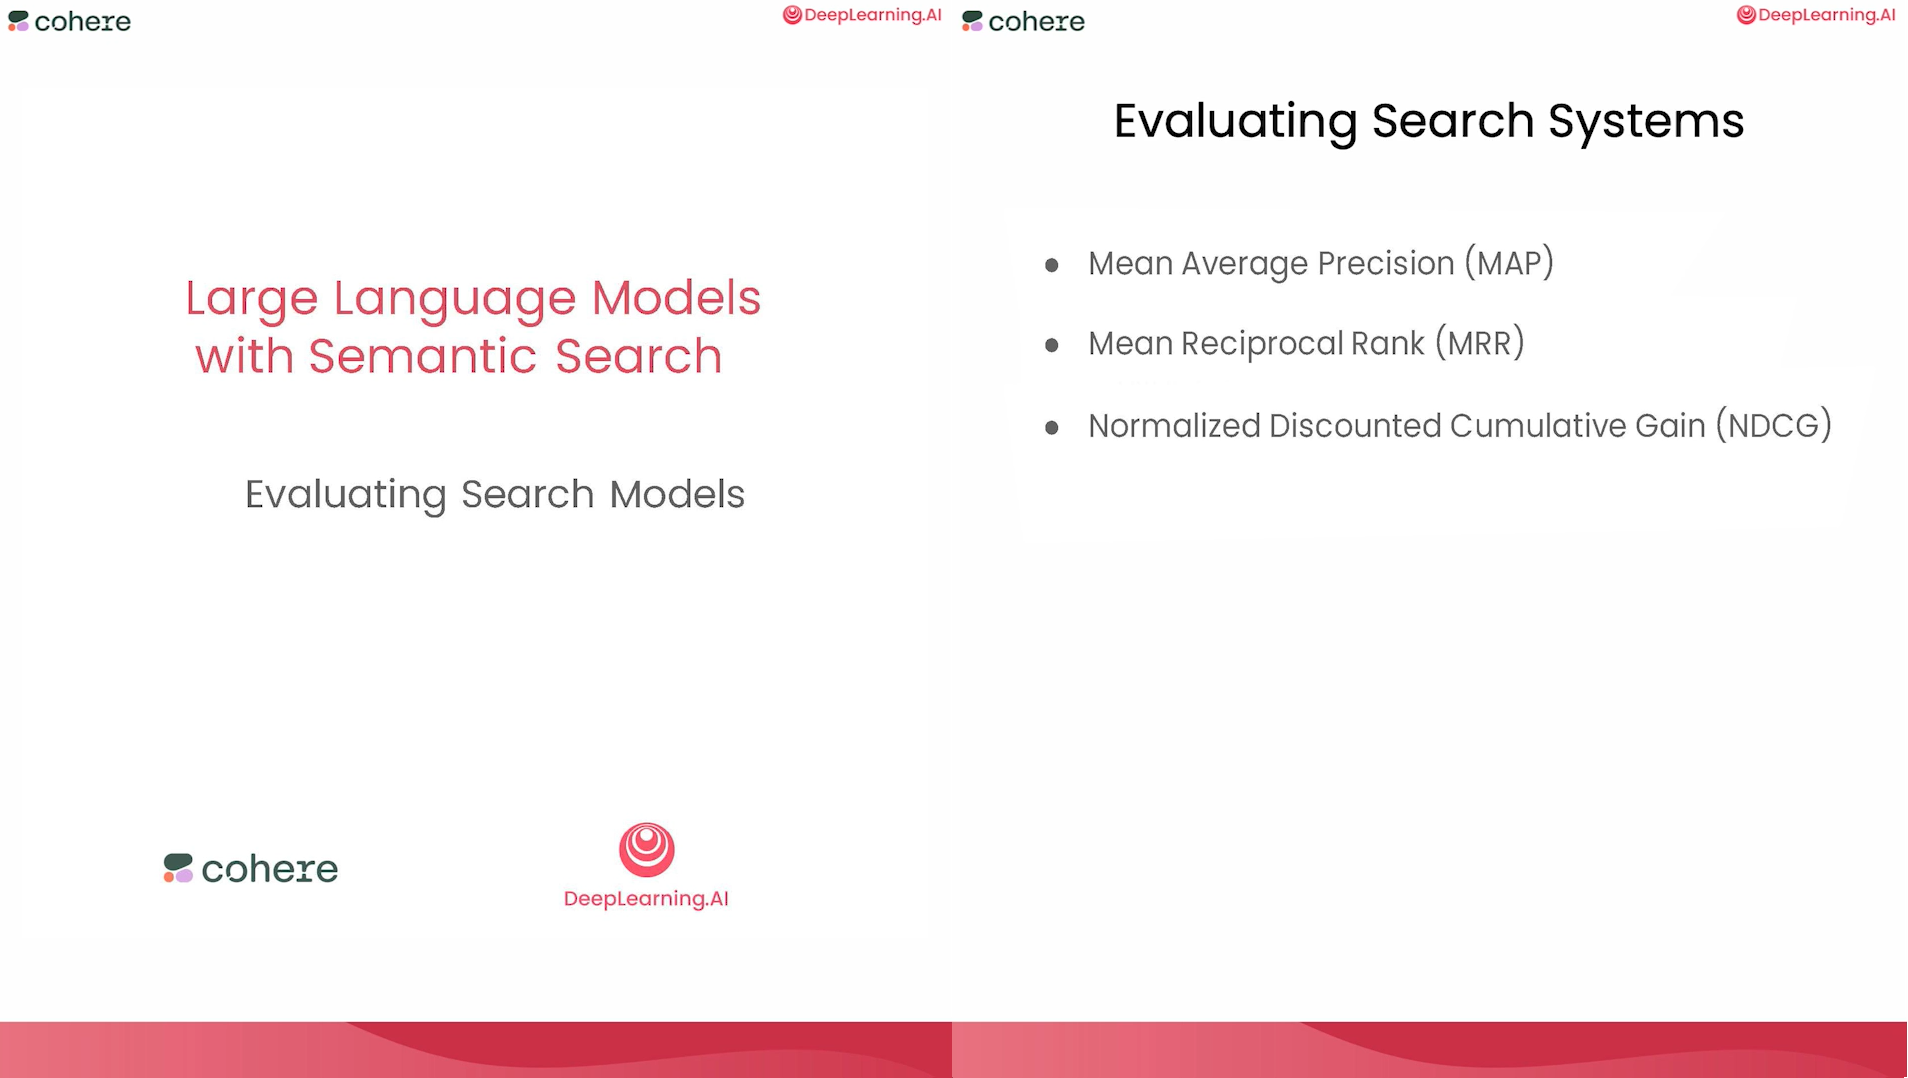

Now, how would you make a test set for evaluating these models? 
Well, a good test set would be one containing queries, and correct responses, and then, you can compare these correct responses with the responses that the model gives you in a very similar way as you would find the accuracy or precision, or recall of a classification model. 
If you'd like to learn more about evaluating search systems, we are going to put some links to articles in the resources for you to take a look at more carefully.